In [1]:
%load_ext autoreload

import sys
import copy
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning")
import json
import collections
import itertools
from functools import partial
import importlib

import numpy as onp
from jax.config import config
config.update("jax_debug_nans", False)
# config.update("jax_log_compiles", True)
# config.update("jax_enable_x64", True)

from tqdm import tqdm

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import optax
import matplotlib.pyplot as plt

import numpy as onp
import jax
import pandas as pd
import haiku as hk
import ot


import utils
import metrics
import time
import plot
import stein
import kernels
import distributions
import nets
import kernel_learning
import models
import flows

from jax.experimental import optimizers

key = random.PRNGKey(0)
key, subkey = random.split(key)

from jax.scipy.stats import norm

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Test general gradient estimator
* generate sets of samples from different distributions
* train gradient approximator on all those sets
* see how well it does

In [2]:
# set up model
phi_sizes = [32, 32]
class Hypernetwork(hk.Module):
    def __init__(self,
                 sizes,
                 output_size,
                 unravel_fun: callable = lambda x: x,
                 name: str = None):
        """
        Take care to choose sizes[-1] equal to the particle dimension.
        init_x should have shape (n, d)
        """
        super().__init__(name=name)
        self.sizes = sizes
        self.output_size = output_size
#         self.w_init = hk.initializers.VarianceScaling(scale=2.0)
        self.w_init = hk.initializers.Orthogonal(scale=2.)
        self.unravel_fun = unravel_fun

    def __call__(self, x):
        """args: a batch of samples, shaped (n, d)"""
        n, d = x.shape
        phi = hk.nets.MLP(output_sizes=self.sizes,
                          w_init=self.w_init,
                          activation=jax.nn.swish,
                          activate_final=True)

        compute_params = hk.Sequential([
            phi,
            partial(np.mean, axis=0),
            hk.Linear(128, w_init=self.w_init),
            jax.nn.swish,
            hk.Linear(self.output_size, w_init=self.w_init),
        ])
        return self.unravel_fun(compute_params(x))

field = hk.transform(lambda x: nets.VectorField([16, 16, 16, 2])(x))
x = np.ones((5, 2))

field_params = field.init(subkey, x)
field_params_flat, unravel = jax.flatten_util.ravel_pytree(field_params)
hypernet = hk.transform(lambda samples: Hypernetwork(sizes=phi_sizes,
                                                     output_size=field_params_flat.shape[0],
                                                     unravel_fun=unravel)(samples))
key, subkey = random.split(key)
params = hypernet.init(subkey, x)

def get_field(particles, params):
    norm = nets.get_norm(particles)
    field_params = hypernet.apply(params, None, particles)
    def v(x):
        return field.apply(field_params, None, norm(x))
    return v

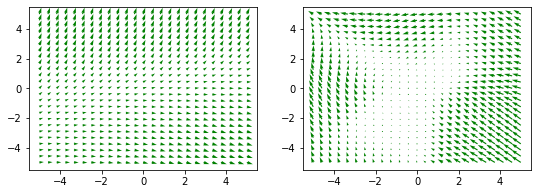

In [3]:
%matplotlib inline

# plot output
fig, axs = plt.subplots(1, 2, figsize=[9, 3])
axs = axs.flatten()
particles = distributions.Gaussian([0, 1], [15, 2]).sample(100)
v_init = get_field(particles, params)
plot.plot_gradient_field(v_init, axs[0])

# compare:
usual_v_init = lambda x: field.apply(field_params, None, x)
plot.plot_gradient_field(usual_v_init, axs[1])

In [34]:
# set up target
target = distributions.Gaussian([0, 0], 1)
target_logp = target.logpdf
def get_v(logq: callable):
    def v(x):
        return grad(logq)(x) - grad(target_logp)(x)
    return v

dist = distributions.Banana([0, -3], [2, 1])
logq = dist.logpdf
true_v = get_v(logq)

@partial(jit, static_argnums=1)
def true_stein_discrepancy(particles, f):
    """Assuming particles are from dist q (Banana)"""
    stein_discrepancy = np.mean(vmap(
        lambda x: np.dot(f(x), grad(target_logp)(x) - grad(logq)(x))
    )(particles), axis=0)
    return stein_discrepancy


def loss_fn(params, particles):
    f = utils.negative(get_field(particles, params))
    stein_discrepancy = stein.stein_discrepancy(particles, target_logp, f)
    true_sd = true_stein_discrepancy(particles, f)
    l2_f_sq = utils.l2_norm_squared(particles, f)
    loss = -stein_discrepancy + 1/2 * l2_f_sq

    aux = [loss, stein_discrepancy, l2_f_sq, true_sd]
    return loss, aux


def compute_loss(samples, v):
    sd = stein.stein_discrepancy(samples, target_logp, (v))
    return -sd + 1/2 * utils.l2_norm_squared(samples, v)

key, subkey = random.split(key)
samples = dist.sample(1000, subkey)
true_loss = compute_loss(samples, utils.negative(true_v))
true_sd = true_stein_discrepancy(samples, utils.negative(true_v))
true_sd_check = stein.stein_discrepancy(samples, target_logp, utils.negative(true_v))

print("True Loss:", true_loss)
print("True SD:", true_sd)
print("True SD:", true_sd_check)

True Loss: -8.775875
True SD: 16.620964
True SD: 17.086357


In [19]:
def generator(key):
    while True:
        key, subkey = random.split(key)
        yield dist.sample(1000, key=subkey)
gen = generator(subkey)

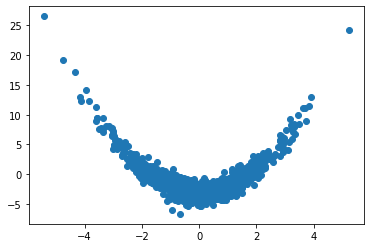

In [20]:
%matplotlib inline
plot.scatter(next(gen))

In [21]:
# optimizer
opt = optax.adam(1e-4)
opt_state = opt.init(params)

@jit
def step(params, opt_state, samples):
    grads, aux = grad(loss_fn, has_aux=True)(params, samples)
    grads, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, grads)
    return params, opt_state, aux

In [22]:
losses = []
sds = []
true_sds = []
l2s = []

In [23]:
utils.l2_norm_squared(samples, true_v)

DeviceArray(17.785477, dtype=float32)

In [24]:
for _ in tqdm(range(500)):
    samples = next(gen)
    params, opt_state, aux = step(params, opt_state, samples)
    loss, sd, l2, true_sd = aux
    losses.append(loss)
    sds.append(sd)
    l2s.append(l2)
    true_sds.append(true_sd)

100%|██████████| 500/500 [00:09<00:00, 50.33it/s]


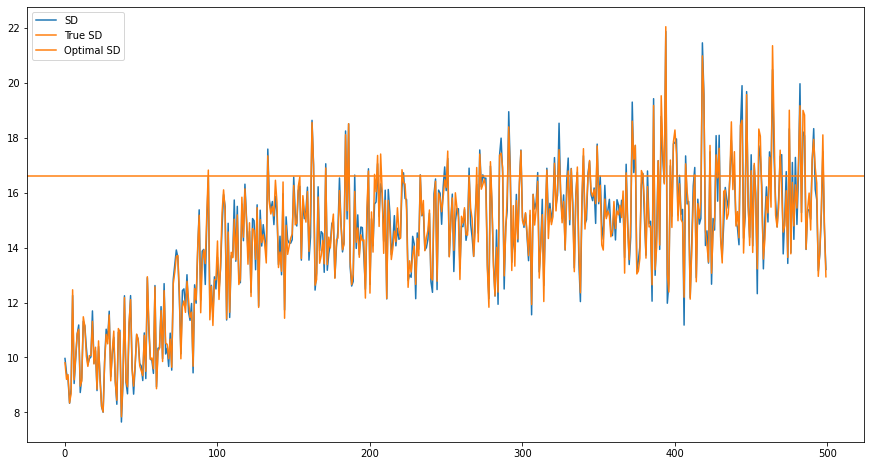

In [35]:
%matplotlib inline
plt.subplots(figsize=[15, 8])
plt.plot(sds, label="SD")
plt.plot(true_sds, label="True SD")
plt.axhline(true_sd, label="Optimal SD", color="tab:orange")
plt.plot
plt.legend()

In [26]:
sample_list = [next(gen) for _ in range(100)]

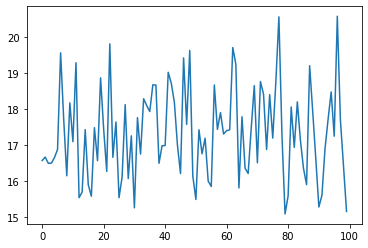

In [27]:
plt.plot([true_stein_discrepancy(samples, utils.negative(true_v)) for samples in sample_list])

# Plot learned field

In [30]:
# Sample
samples = dist.sample(100)
v = get_field(samples, params)

/home/lauro/code/msc-thesis/svgd/kernel_learning/plot.py:201: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  return ax.pcolormesh(*meshgrid, cmap=cmap, **kwargs)


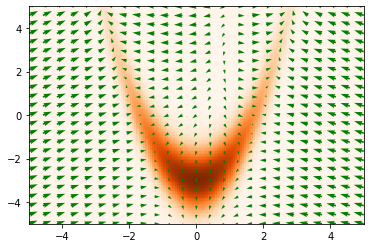

In [31]:
plot.plot_fun_2d(dist.pdf)
plot.plot_gradient_field(v)

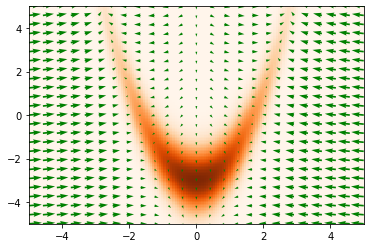

In [32]:
plot.plot_fun_2d(dist.pdf)
plot.plot_gradient_field(vmap(true_v))

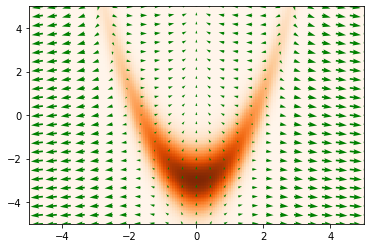

In [33]:
plot.plot_fun_2d(dist.pdf)
plot.plot_gradient_field(vmap(grad(lambda x: target_logp(x) - dist.logpdf(x))))

/home/lauro/code/msc-thesis/svgd/kernel_learning/plot.py:201: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  return ax.pcolormesh(*meshgrid, cmap=cmap, **kwargs)


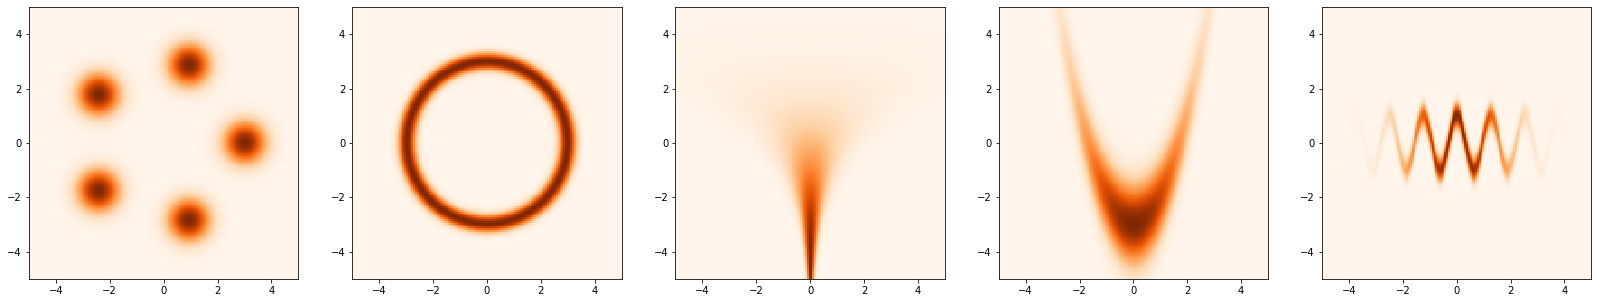

In [112]:
# test distributions
# all of them should be plottable in (-5, 5)
# (these are the ones we sample from; target is fixed at gaussian)

means = np.array([np.exp(2j*np.pi*x) for x in np.linspace(0, 1, 6)[:-1]])
means = np.column_stack((means.real,means.imag))*3
mix = distributions.GaussianMixture(means, .3, np.ones(5))

ring = distributions.Ring(3, .05)
funnel, _ = distributions.funnel.get()
banana = distributions.Banana([0, -3], [2, 1])
squiggle = distributions.Squiggle([0, 0], [2, .1])
dists = (mix, ring, funnel, banana, squiggle)

fig, axs = plt.subplots(1, 5, figsize=[28, 5])
axs = axs.flatten()
for ax, dist in zip(axs, dists):
    plot.plot_fun_2d(dist.pdf, ax=ax)